# Train

In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'lib'))

from train import parse_config, get_features, print_model_to_json

Using TensorFlow backend.
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anrun\anaconda3\envs\EPE_ML\lib\sit

In [2]:
from keras.optimizers import Adam, Nadam
from callbacks import all_callbacks

In [3]:

from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = '../KERAS_gru_model_weights.h5',
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = '../train/train_config_gru.yml',
    jsonModel = '../KERAS_gru_model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)

yamlConfig

Loading configuration from ../train/train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [4]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [5]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()



Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.load_weights(options.inputModel)
model.summary()
startlearningrate=0.0001
adam = Adam(lr=startlearningrate)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=os.curdir + '\\training_callbacks')

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                validation_split = 0.25, shuffle = True, callbacks = callbacks.callbacks)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1620      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer

59261/59261 [==============================] - 1s - loss: 1.3875 - acc: 0.4624 - val_loss: 1.3565 - val_acc: 0.4742
Epoch 9/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.3692 - acc: 0.4684
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00008: val_loss improved from 1.35654 to 1.33944, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00008: val_loss improved from 1.35654 to 1.33944, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00008: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00008: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.3683 - acc: 0.4688 - val_loss: 1.3394 - val_acc: 0.4828
Epoch 10/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.3518 - acc: 0.4760
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00009: val_

59261/59261 [==============================] - 1s - loss: 1.2556 - acc: 0.5202 - val_loss: 1.2335 - val_acc: 0.5358
Epoch 21/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.2490 - acc: 0.5227
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00020: val_loss improved from 1.23350 to 1.22727, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00020: val_loss improved from 1.23350 to 1.22727, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00020: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00020: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.2490 - acc: 0.5228 - val_loss: 1.2273 - val_acc: 0.5387
Epoch 22/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.2431 - acc: 0.5262
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00021: val

Epoch 00031: val_loss improved from 1.18042 to 1.17625, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00031: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00031: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1977 - acc: 0.5481 - val_loss: 1.1763 - val_acc: 0.5640
Epoch 33/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.1946 - acc: 0.5491
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00032: val_loss improved from 1.17625 to 1.17258, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00032: val_loss improved from 1.17625 to 1.17258, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00032: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00032: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***cal

59261/59261 [==============================] - 1s - loss: 1.1595 - acc: 0.5664 - val_loss: 1.1383 - val_acc: 0.5787
Epoch 44/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1596 - acc: 0.5660
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00043: val_loss improved from 1.13831 to 1.13493, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00043: val_loss improved from 1.13831 to 1.13493, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00043: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00043: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1581 - acc: 0.5664 - val_loss: 1.1349 - val_acc: 0.5811
Epoch 45/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.1549 - acc: 0.5684
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00044: val

59261/59261 [==============================] - 1s - loss: 1.1298 - acc: 0.5816 - val_loss: 1.1074 - val_acc: 0.5953
Epoch 56/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1292 - acc: 0.5834
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00055: val_loss improved from 1.10744 to 1.10505, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00055: val_loss improved from 1.10744 to 1.10505, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00055: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00055: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1280 - acc: 0.5836 - val_loss: 1.1050 - val_acc: 0.5957
Epoch 57/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1247 - acc: 0.5864
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00056: val

59261/59261 [==============================] - 1s - loss: 1.1060 - acc: 0.5967 - val_loss: 1.0835 - val_acc: 0.6074
Epoch 68/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1074 - acc: 0.5971
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00067: val_loss improved from 1.08351 to 1.08124, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00067: val_loss improved from 1.08351 to 1.08124, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00067: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00067: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.1055 - acc: 0.5982 - val_loss: 1.0812 - val_acc: 0.6094
Epoch 69/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.1012 - acc: 0.5986
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00068: val

59261/59261 [==============================] - 1s - loss: 1.0878 - acc: 0.6083 - val_loss: 1.0630 - val_acc: 0.6209
Epoch 80/100
57344/59261 [============================>.] - ETA: 0s - loss: 1.0856 - acc: 0.6084
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00079: val_loss improved from 1.06298 to 1.06181, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00079: val_loss improved from 1.06298 to 1.06181, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5
Epoch 00079: saving model to .\training_callbacks/KERAS_check_model_epoch79.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0852 - acc: 0.6085 - val_loss: 1.0618 - val_acc: 0.6209
Epoch 81/100
58368/59261 [============================>.] - ETA: 0s - loss: 1.0834 - acc: 0.6112
**

saving losses to .\training_callbacks\losses.log
Epoch 00090: val_loss improved from 1.04573 to 1.04373, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00090: val_loss improved from 1.04573 to 1.04373, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5
Epoch 00090: saving model to .\training_callbacks/KERAS_check_model_last.h5
Epoch 00090: saving model to .\training_callbacks/KERAS_check_model_last_weights.h5

***callbacks end***

59261/59261 [==============================] - 1s - loss: 1.0677 - acc: 0.6219 - val_loss: 1.0437 - val_acc: 0.6344
Epoch 92/100
56320/59261 [===========================>..] - ETA: 0s - loss: 1.0679 - acc: 0.6228
***callbacks***
saving losses to .\training_callbacks\losses.log
Epoch 00091: val_loss improved from 1.04373 to 1.04234, saving model to .\training_callbacks/KERAS_check_best_model.h5
Epoch 00091: val_loss improved from 1.04373 to 1.04234, saving model to .\training_callbacks/KERAS_check_best_model_weights.h5

# Eval

In [12]:
def makeRoc(features_val, labels, labels_val, model):
    print('in makeRoc()')
    if 'j_index' in labels: labels.remove('j_index')

    predict_test = model.predict(features_val)

    df = pd.DataFrame()
    
    fpr = {}
    tpr = {}
    auc1 = {}
    
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
            
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig("mygraph.png")
#     plt.savefig('%s/ROC.pdf'%(options.outputDir))
#     plt.savefig('%s/ROC.pdf' %(outputDir))
    return predict_test

Plot ROC curve
in makeRoc()


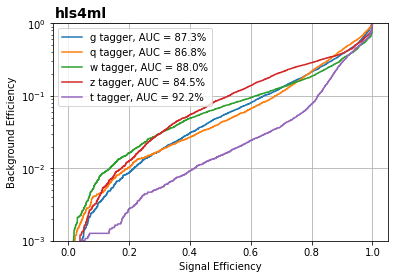

In [13]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)

In [14]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

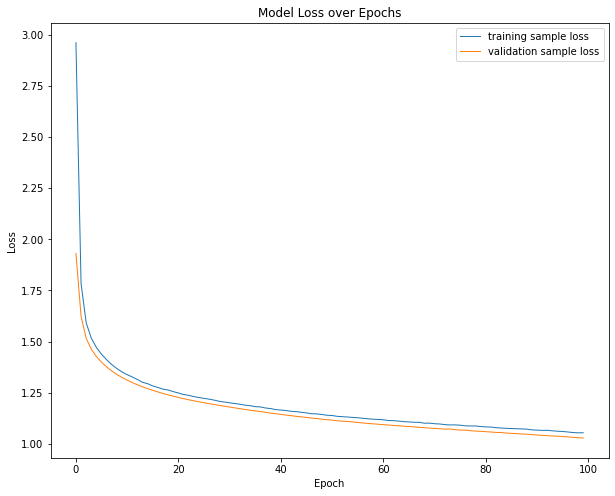

In [15]:
learningCurve(history)